In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
import random
import pandas_profiling
from pandas_profiling.utils.cache import cache_file

/opt/conda/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# External Data and Interim Data File Locations
ext_data = '../data/external/'
interim_data = '../data/interim/'
report_figures = '../reports/figures/'

In [3]:
df = pd.read_csv(ext_data + 'name_pairs.txt', sep=",", names=['name_a', 'name_b'], header=None)
df.shape

(17510, 2)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17510 entries, 0 to 17509
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name_a  17510 non-null  object
 1   name_b  17510 non-null  object
dtypes: object(2)
memory usage: 273.7+ KB


In [5]:
df.sample(10)

,name_a,name_b
9380,Lu,Lucinda
4970,Freda,Fredde
15371,Styopushka,Styopanka
16073,Titi,Tiffany
62,Abigail,Tabitha
16497,Vanessa,Van
947,Annie,Anna
8251,Kolyunya,Nikolasha
8971,Linde,Minde
13296,Petra,Nelleke


In [6]:
# Positive Class
df['target'] = 1

### Create Random Sample of Negative Class

In [7]:
all_names = df.loc[:, 'name_a':'name_b'].values.tolist()
print(len(all_names))
all_names[:5]

17510


[['Aad', 'Adriaan'],
 ['Aake', 'Aarne'],
 ['Aake', 'Aarno'],
 ['Aake', 'Arska'],
 ['Aandrea', 'Drea']]

In [8]:
unique_names = list(set([item for items in all_names for item in items]))
print(len(unique_names))
unique_names[:5]

5877


['Joco', 'Tunja', 'Biel', 'Anastazie', 'Nick']

In [9]:
alt_pairs = list(zip(df.name_a, df.name_b))+ list(zip(df.name_b, df.name_a))
print(len(alt_pairs))
alt_pairs[:5]

35020


[('Aad', 'Adriaan'),
 ('Aake', 'Aarne'),
 ('Aake', 'Aarno'),
 ('Aake', 'Arska'),
 ('Aandrea', 'Drea')]

In [10]:
comb = list(combinations(unique_names, 2))
print(len(comb))
comb[:5]

17266626


[('Joco', 'Tunja'),
 ('Joco', 'Biel'),
 ('Joco', 'Anastazie'),
 ('Joco', 'Nick'),
 ('Joco', 'Maxie')]

In [11]:
non_alt = list(set(comb) - set(alt_pairs))
print(len(non_alt))
non_alt[:5]

17249462


[('Zadock', 'Jaroslaw'),
 ('Terry', 'Gigi'),
 ('Rodri', 'Con'),
 ('Nikke', 'Jaclin'),
 ('Krzysieczek', 'Yosi')]

In [12]:
# Undersample the negative class for 1:4 class imbalance instead of 1:1000 extreme class imbalance
non_alt = pd.DataFrame(random.choices(non_alt, k=70040), columns=['name_a', 'name_b'])
non_alt.shape

(70040, 2)

In [13]:
# Negative Class
non_alt['target'] = 0

In [14]:
non_alt.sample(10)

,name_a,name_b,target
40594,Drazo,Burt,0
5087,Mose,Miguelinho,0
30191,Nina,Electra,0
6539,Anneliese,Alphus,0
5571,Hermoine,Jouni,0
61874,Hob,Nicke,0
58522,Nadenka,Kristian,0
26993,Jacint,Othello,0
29980,Raf,Ilj,0
34055,Manuel,Drejc,0


In [15]:
print('positive class ratio 1:{}'.format(int(len(non_alt)/len(df))))

positive class ratio 1:4


In [16]:
df = pd.concat([df, non_alt])
df.shape

(87550, 3)

In [17]:
df.sample(10)

,name_a,name_b,target
20191,Lorne,Mertsi,0
16200,Lele,Andreandrijica,0
17719,Nadine,Friedrich,0
37,Antoni,Kikine,0
25145,Nolle,Mayca,0
41647,Louanne,Hepsabah,0
56393,Sica,Luboslav,0
21691,Krasimir,Trude,0
56044,Arlene,Eurydice,0
17154,Xandy,Xan,1


Text(0.5, 0, 'Count')

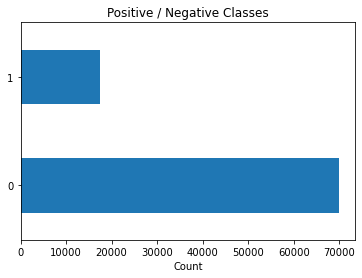

In [18]:
ax = df.target.value_counts(dropna=False).plot(kind='barh', title='Positive / Negative Classes')
ax.set_xlabel('Count')

In [19]:
# Save output to interim data folder as csv file
df.to_csv(interim_data + 'pos_neg_class_file.csv', index=False)

In [20]:
profile_report = df.profile_report(explorative=True, html={'style': {'full_width': True}})
profile_report.to_file(report_figures + "wrangled_data_profile.html")

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 270.51it/s]
